In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import torchvision
from matplotlib import pyplot as plt

from utils import plot_image, plot_curve, one_hot

In [2]:
batch_size = 512

# step1. load dataset
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('mnist_data', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),  # 将原格式（numpy）转换成tendor，以适用于torch
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))  # 将数据正则化以提升性能
                               ])),
    batch_size=batch_size, shuffle=True)  # shuffle=True：将数据打乱

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('mnist_data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size, shuffle=False)

torch.Size([512, 1, 28, 28]) torch.Size([512]) tensor(-0.4242) tensor(2.8215)


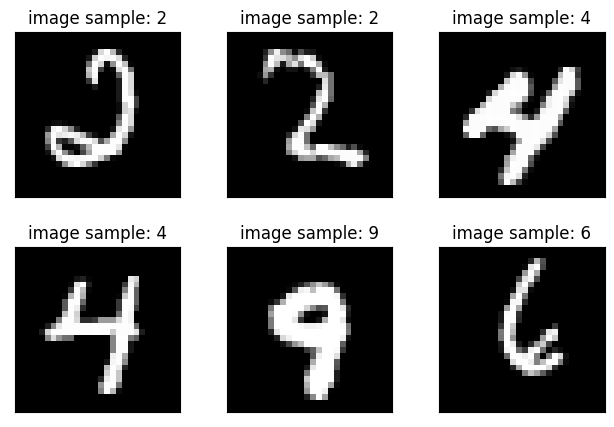

In [3]:
# 展示读取结果
x, y = next(iter(train_loader))
print(x.shape, y.shape, x.min(), x.max())
plot_image(x, y, 'image sample')

In [4]:
# 定义各层

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # xw+b
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # x: [b, 1, 28, 28]
        # h1 = relu(xw1+b1)
        x = F.relu(self.fc1(x))
        # h2 = relu(h1w2+b2)
        x = F.relu(self.fc2(x))
        # h3 = h2w3+b3
        x = self.fc3(x)  # 最后一层一般不用ReLU()激活函数

        return x
    
net = Net()
# [w1, b1, w2, b2, w3, b3]
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

0 0 0.10930202901363373
0 10 0.09468503296375275
0 20 0.08358083665370941
0 30 0.07791551202535629
0 40 0.07130556553602219
0 50 0.0669231191277504
0 60 0.06368820369243622
0 70 0.059838853776454926
0 80 0.05783408135175705
0 90 0.05545065551996231
0 100 0.05471593141555786
0 110 0.05032888799905777
1 0 0.0497785322368145
1 10 0.048361681401729584
1 20 0.046196263283491135
1 30 0.046240270137786865
1 40 0.045440323650836945
1 50 0.044583410024642944
1 60 0.04387673735618591
1 70 0.0442255362868309
1 80 0.04197346419095993
1 90 0.042772483080625534
1 100 0.03967816382646561
1 110 0.0380701869726181
2 0 0.039399631321430206
2 10 0.03782607242465019
2 20 0.04067846015095711
2 30 0.036807797849178314
2 40 0.035522811114788055
2 50 0.03679011017084122
2 60 0.036154426634311676
2 70 0.03467954695224762
2 80 0.033007074147462845
2 90 0.03416431322693825
2 100 0.0347260907292366
2 110 0.034708570688962936


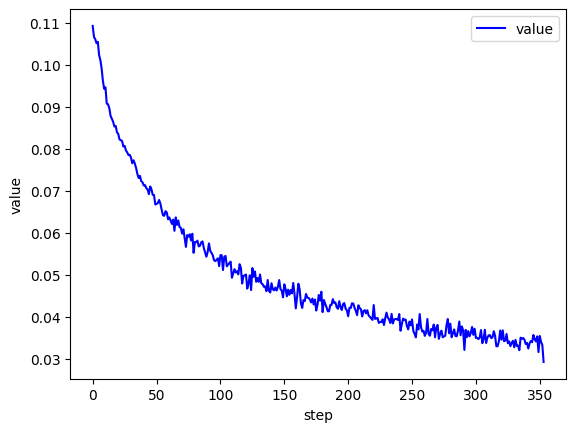

test acc: 0.8843


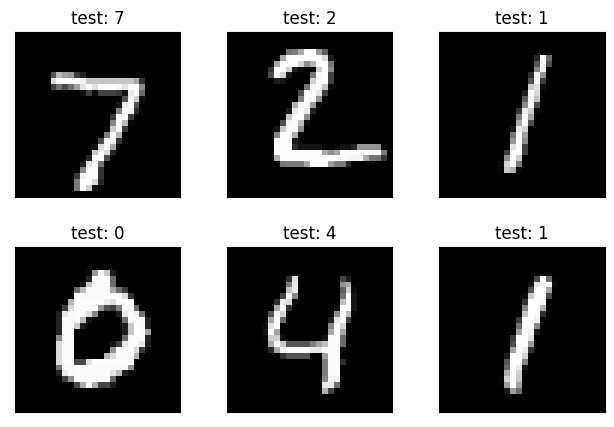

In [5]:
train_loss = []

for epoch in range(3):  # 迭代三遍

    for batch_idx, (x, y) in enumerate(train_loader):

        # x: [b, 1, 28, 28], y: [512]
        # [b, 1, 28, 28] => [b, 784]
        x = x.view(x.size(0), 28*28)
        # => [b, 10]
        out = net(x)
        # [b, 10]
        y_onehot = one_hot(y)
        # loss = mse(out, y_onehot)
        loss = F.mse_loss(out, y_onehot)

        optimizer.zero_grad()
        loss.backward()
        # w' = w - lr*grad
        optimizer.step()

        train_loss.append(loss.item())

        if batch_idx % 10==0:
            print(epoch, batch_idx, loss.item())

plot_curve(train_loss)
# we get optimal [w1, b1, w2, b2, w3, b3]


total_correct = 0
for x,y in test_loader:
    x  = x.view(x.size(0), 28*28)
    out = net(x)
    # out: [b, 10] => pred: [b]
    pred = out.argmax(dim=1)
    correct = pred.eq(y).sum().float().item()
    total_correct += correct

total_num = len(test_loader.dataset)
acc = total_correct / total_num
print('test acc:', acc)

x, y = next(iter(test_loader))
out = net(x.view(x.size(0), 28*28))
pred = out.argmax(dim=1)
plot_image(x, pred, 'test')